<a href="https://colab.research.google.com/github/LeeDongN/Medica_AI2/blob/main/Features_from_single_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
import numpy as np
import pandas as pd
import scipy as sc
import csv
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [178]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
data_path = '/content/W0000.CSV'

data = pd.read_csv(data_path, skiprows = 24)

# data.loc[0] = [ data_ori.columns[0], data_ori.columns[1] ]

data.columns = ['X', 'Y']

In [6]:
print(data)

              X             Y
0     1475.0198  4.224000e-07
1     1475.0397  3.886000e-07
2     1475.0595  2.803000e-07
3     1475.0794  4.941000e-07
4     1475.0992  1.226000e-06
...         ...           ...
6295  1599.9206  9.652000e-07
6296  1599.9405  1.532000e-06
6297  1599.9603  1.209000e-06
6298  1599.9802  1.052000e-06
6299  1600.0000  1.311000e-06

[6300 rows x 2 columns]


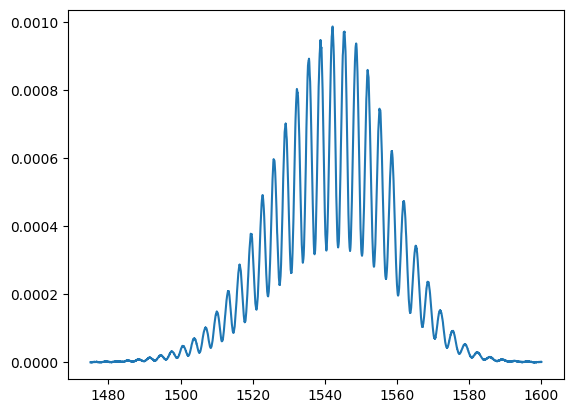

In [7]:
plt.plot (data['X'], data['Y'])

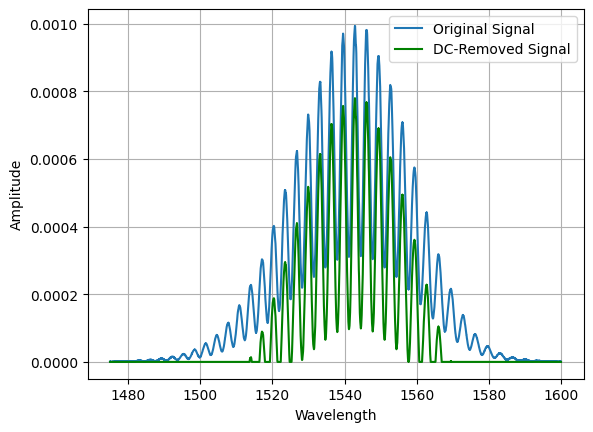

In [190]:
# Implementing a simple DC removal function
def remove_dc(signal):
    # Calculate the mean of the signal
    signal_mean = np.mean(signal)
    # Remove the mean from the signal
    dc_removed_signal = signal - signal_mean
    return dc_removed_signal

dc_removed_Y = np.maximum(remove_dc(data['Y']),0)

# Plot the original waveform and the DC-removed signal with positive amplitudes
plt.plot(data['X'], data['Y'], label='Original Signal')
plt.plot(data['X'], dc_removed_Y, label='DC-Removed Signal', color='green')
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


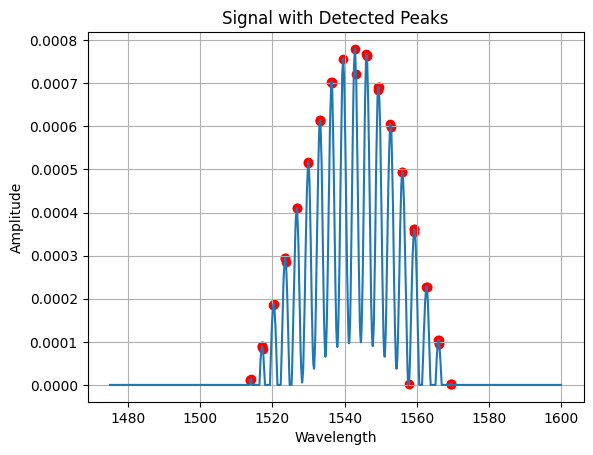

In [192]:
# A simple peak detection system that takes a value and compares it with a value before and after
def detect_peaks(signal):
    peaks = []
    for i in range(1, len(signal) - 1):
        if (signal[i] > signal[i - 1]) and (signal[i] > signal[i + 1]):
            peaks.append(i)
    return peaks

# Applies peak detection on dc_removed_Y signal
local_maxima_indices = detect_peaks(dc_removed_Y)
local_maxima_x = data['X'][local_maxima_indices]
local_maxima_y = dc_removed_Y[local_maxima_indices]

# Plot the signal with detected peaks
plt.plot(data['X'], dc_removed_Y)
plt.scatter(local_maxima_x, local_maxima_y, color='red')
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
plt.title('Signal with Detected Peaks')
plt.grid(True)

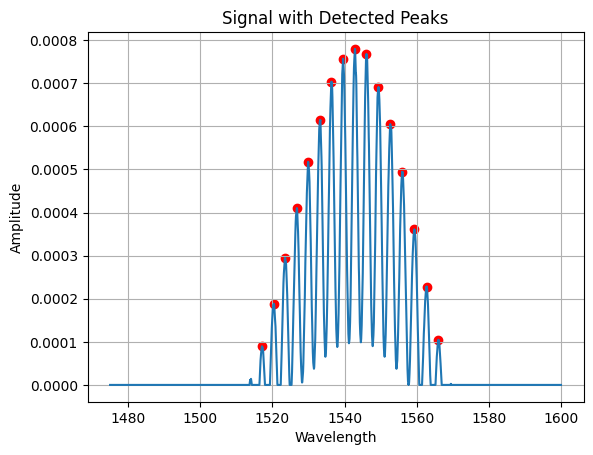

Threshold: 7.795441489253968e-05
Number of peaks: 16


In [207]:
def detect_peaks(signal, threshold=None, min_distance=1, prominence=None):
    if threshold is None:
        # Set threshold as a percentage of the maximum peak
        max_peak = np.max(signal)
        threshold = 0.1 * max_peak  # Adjust the percentage as needed
    peaks, _ = find_peaks(signal, height=threshold, distance=min_distance, prominence=prominence)
    return peaks, threshold

# Apply peak detection with dynamic threshold
min_distance = 100  # Set the minimum distance between peaks
local_maxima_indices, threshold = detect_peaks(dc_removed_Y, min_distance=min_distance)
local_maxima_x = data['X'][local_maxima_indices]
local_maxima_y = dc_removed_Y[local_maxima_indices]

# Plot the signal with detected peaks
plt.plot(data['X'], dc_removed_Y)
plt.scatter(local_maxima_x, local_maxima_y, color='red')
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
plt.title('Signal with Detected Peaks')
plt.grid(True)
plt.show()
print("Threshold:", threshold)
num_peaks = len(local_maxima_indices)
print("Number of peaks:", num_peaks)

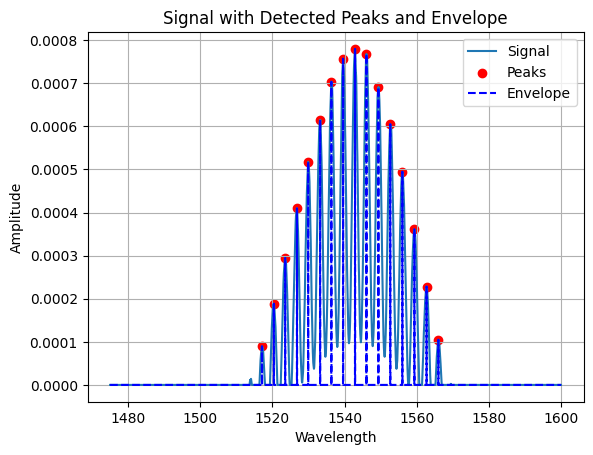

Area under the curve (Simpson's rule): 0.0001566654007452246
Area under the curve (Trapezoidal rule): 0.0001509029678689373


In [208]:
from scipy.integrate import simps

# Calculate area under the curve using Simpson's rule
def calculate_area_under_curve_simps(x, y):
    area = simps(y, x)
    return area

# Calculate area under the curve using the trapezoidal rule
def calculate_area_under_curve_trapz(x, y):
    area = np.trapz(y, x)
    return area

# Create envelope around the peaks
envelope = create_envelope(dc_removed_Y, local_maxima_indices)

# Plot the signal with detected peaks and envelope
plt.plot(data['X'], dc_removed_Y, label='Signal')
plt.scatter(local_maxima_x, local_maxima_y, color='red', label='Peaks')
plt.plot(data['X'], envelope, color='blue', linestyle='--', label='Envelope')
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
plt.title('Signal with Detected Peaks and Envelope')
plt.legend()
plt.grid(True)
plt.show()

# Calculate area under the curve using Simpson's rule
area_under_curve_simps = calculate_area_under_curve_simps(data['X'], envelope)
print("Area under the curve (Simpson's rule):", area_under_curve_simps)

# Calculate area under the curve using the trapezoidal rule
area_under_curve_trapz = calculate_area_under_curve_trapz(data['X'], envelope)
print("Area under the curve (Trapezoidal rule):", area_under_curve_trapz)


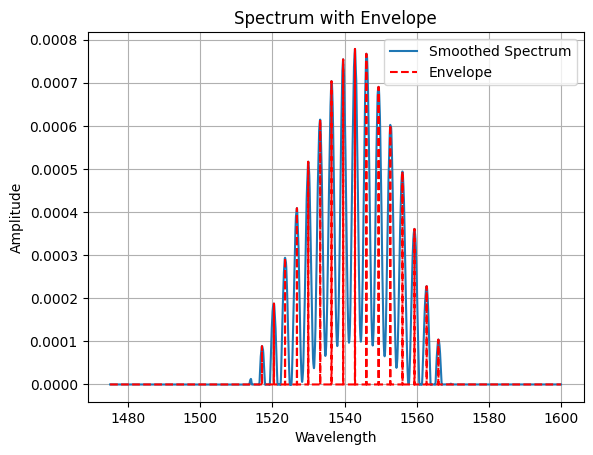

In [210]:
from scipy.signal import savgol_filter

# Smooth the spectrum
smoothed_spectrum = savgol_filter(dc_removed_Y, window_length=15, polyorder=3)

# Find local maxima in the smoothed spectrum
local_maxima_indices, _ = detect_peaks(smoothed_spectrum, min_distance=50)

# Create envelope around the spectrum
envelope = create_envelope(smoothed_spectrum, local_maxima_indices)

# Plot the spectrum with envelope
plt.plot(data['X'], smoothed_spectrum, label='Smoothed Spectrum')
plt.plot(data['X'], envelope, color='red', linestyle='--', label='Envelope')
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
plt.title('Spectrum with Envelope')
plt.legend()
plt.grid(True)
plt.show()


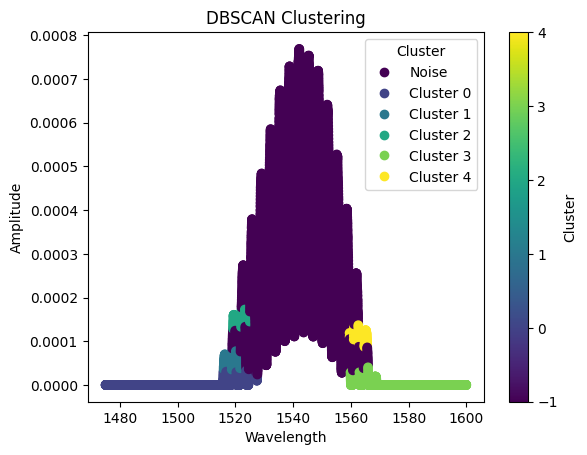

In [146]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Combining wavelength and amplitude
X = np.column_stack((data['X'], dc_removed_Y))

# Feature standardization
X_scaled = StandardScaler().fit_transform(X)

# Applying DBSCAN
eps = 0.09  # neighborhood distance threshold
min_samples = 40  # minimum number of samples
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_scaled)

# Getting cluster labels and plotting
cluster_labels = dbscan.labels_
scatter = plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
plt.title('DBSCAN Clustering')
legend_labels = np.unique(cluster_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {label}' if label != -1 else 'Noise' for label in legend_labels], title='Cluster')

plt.colorbar(label='Cluster')
plt.show()


In [123]:
print(cluster_labels)

[0 0 0 ... 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


TypeError: scatter() missing 1 required positional argument: 'y'

<Figure size 1000x600 with 0 Axes>

In [144]:
print(X[:, ])

[1475.0198 1475.0397 1475.0595 ... 1599.9603 1599.9802 1600.    ]


In [148]:
import numpy as np
import pandas as pd
import scipy as sc
import csv
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
import pandas as pd

# List to store all DataFrames
data_list = []

# Reading and appending each CSV file to the list
for i in range(1, 9):
    filename = f'/content/W000{i}.CSV'
    data = pd.read_csv(filename, skiprows=24)
    data_list.append(data)

# Concatenating all DataFrames into a single one
combined_data = pd.concat(data_list, ignore_index=True)

# Displaying the combined DataFrame
print(combined_data.head())

   1475.0000    7.177E-007  9.487E-007  1.475E-007  9.459E-007  2.635E-007  \
0  1475.0198  6.042000e-07         NaN         NaN         NaN         NaN   
1  1475.0397  7.064000e-07         NaN         NaN         NaN         NaN   
2  1475.0595  8.922000e-07         NaN         NaN         NaN         NaN   
3  1475.0794  9.271000e-07         NaN         NaN         NaN         NaN   
4  1475.0992  2.986000e-07         NaN         NaN         NaN         NaN   

   1.307E-007  8.774E-007  6.439E-007  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  


In [164]:
print(combined_data)

       1475.0000    7.177E-007  9.487E-007  1.475E-007  9.459E-007  \
0      1475.0198  6.042000e-07         NaN         NaN         NaN   
1      1475.0397  7.064000e-07         NaN         NaN         NaN   
2      1475.0595  8.922000e-07         NaN         NaN         NaN   
3      1475.0794  9.271000e-07         NaN         NaN         NaN   
4      1475.0992  2.986000e-07         NaN         NaN         NaN   
...          ...           ...         ...         ...         ...   
50395  1599.9206           NaN         NaN         NaN         NaN   
50396  1599.9405           NaN         NaN         NaN         NaN   
50397  1599.9603           NaN         NaN         NaN         NaN   
50398  1599.9802           NaN         NaN         NaN         NaN   
50399  1600.0000           NaN         NaN         NaN         NaN   

       2.635E-007  1.307E-007  8.774E-007    6.439E-007  
0             NaN         NaN         NaN           NaN  
1             NaN         NaN         NaN  

IndexError: index 2 is out of bounds for axis 0 with size 2